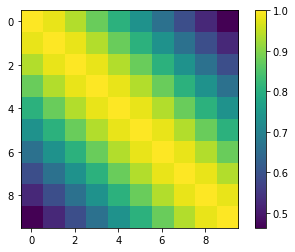

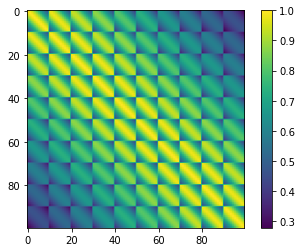

In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import itertools 
import math
from mpl_toolkits.mplot3d import Axes3D  
from scipy import optimize
import pandas as pd
#from ipynb.fs.full.covariance_matrix import *
%run covariance_matrix.ipynb

In [2]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z;   
           s: sigma
           r: rho
           b: beta
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

def lorenz_1step(x, y, z, s=10, r=28, b=2.667,dt = 0.001):
    x_dot, y_dot, z_dot = lorenz(x, y, z)
    x_next = x + (x_dot * dt)
    y_next = y + (y_dot * dt)
    z_next = z + (z_dot * dt)    
    return x_next, y_next, z_next

In [3]:
def lorenz_attractor(s=10, r=28, b=2.667, dt = 0.001,num_steps = 1000,x0=0.,y0=1.,z0=1.05 ):

    # Need one more for the initial values
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    
    # Set initial values
    #xs[0], ys[0], zs[0] = (0., 1., 1.05)
    
    xs[0] = x0
    ys[0] = y0
    zs[0] = z0
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)

    return xs,ys,zs

In [4]:
def lorenz_attractor_noisy(s=10, r=28, b=2.667, dt = 0.001,num_steps = 1000, B = 0.01*np.eye(3), Q = 1e-2*np.eye(3)):

    # Need one more for the initial values
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    
    # Set initial values
    xs[0], ys[0], zs[0] = (0., 1., 1.05)
    #np.random.seed( 10 )
    x_noise_initital = np.random.multivariate_normal(np.zeros(3),B)
    
    xs[0] += x_noise_initital[0]
    ys[0] += x_noise_initital[1]
    zs[0] += x_noise_initital[2]
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        
        x_noise_step = np.random.multivariate_normal(np.zeros(3),Q)
        
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot * dt) + x_noise_step[0]
        ys[i + 1] = ys[i] + (y_dot * dt) + x_noise_step[1]
        zs[i + 1] = zs[i] + (z_dot * dt) + x_noise_step[2]

    return xs,ys,zs

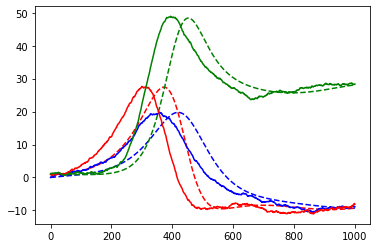

In [5]:
xt,yt,zt = lorenz_attractor(num_steps = 1000)
xb,yb,zb = lorenz_attractor_noisy(num_steps = 1000)

plt.plot(xt,'b--',label ='xt')
plt.plot(yt,'r--',label ='yt')
plt.plot(zt,'g--',label ='zt')

plt.plot(xb,'b',label ='xb')
plt.plot(yb,'r',label ='yb')
plt.plot(zb,'g',label ='zb')

In [11]:
def BLUE(xb,Y,H,B,R): 
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    Y.shape = (Y.size,1)
    dim_x = xb1.size
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.inv(np.dot(H,np.dot(B,np.transpose(H)))+R))) #gain matrix
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))
    +np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))

    return xa,A

#def J(x):   # The rosenbrock function

#    xa = optimize.minimize(J, [2, 2], method="L-BFGS-B")


# https://pypi.org/project/adao/

from adao import adaoBuilder

case = adaoBuilder.New()

#case.set( 'AlgorithmParameters', Algorithm='3DVAR' )
case.setAlgorithmParameters(Algorithm = '3DVAR',
                            Parameters = {"MaximumNumberOfSteps":30,
                                         "CostDecrementTolerance":1.e-3,
                                        "StoreSupplementaryCalculations":["CostFunctionJ","CurrentState",
                                                                        "SimulatedObservationAtOptimum",
                                                                        "SimulatedObservationAtBackground",
                                                                        "JacobianMatrixAtBackground",
                                                                        "JacobianMatrixAtOptimum",
                                                                        "KalmanGainAtOptimum",
                                                                        "APosterioriCovariance"],})
case.set( 'Background',          Vector=[0, 1, 2] )
case.set( 'BackgroundError',     ScalarSparseMatrix=1.0 )
case.set( 'Observation',         Vector=np.array([0.5, 1.5, 2.5]) )
case.set( 'ObservationError',    DiagonalSparseMatrix='1 1 1' )
case.set( 'ObservationOperator', Matrix='1 0 0;0 2 0;0 0 3' )
case.set( 'Observer',            Variable="Analysis", Template="ValuePrinter" )
case.execute()

Analysis [0.24996218 0.79980997 0.95024309]


0

In [13]:
H = np.array([[1,1,0],[2,0,1],[0,0,3]])

B = 0.01*np.eye(3)

R = 0.01*Balgovind_1D(3,1)

x0 = 0.
y0 = 1.
z0 = 1.05

DA_step = 10

num_steps = 1000

train_data1000 = np.array(pd.read_csv('data_1000steps/trainset_withx_1000stepsbis1.csv'))

obs = train_data1000[0,:]

y1 = obs[:1000]

y2 = obs[1000:2000]

y3 = obs[2000:3000]

In [14]:
Xa_evolution = np.zeros((3,num_steps ))

Xb_evolution = np.zeros((3,num_steps ))

for i in range(num_steps):
    
    xa = np.array([x0, y0, z0])
    
    Xa_evolution[0,i] = xa[0]
    
    Xa_evolution[1,i] = xa[1]
    
    Xa_evolution[2,i] = xa[2]    
    
    if i%DA_step ==0 and i > 0 :
        
        xb = np.array([x0, y0, z0])
        
        Y = np.array([y1[i], y2[i], y3[i]])
    
        X_analyzed = BLUE(xb,Y,H,B,R)[0]
        
        xa = X_analyzed[0] 
        
        ya = X_analyzed[1] 
        
        za = X_analyzed[2]
        
        x0, y0, z0 = xa, ya, za 
                
    
    x_next, y_next, z_next = lorenz_1step(x0, y0, z0 , s=10, r=28, b=2.667, dt = 0.001)
        
    x0, y0, z0 = x_next, y_next, z_next

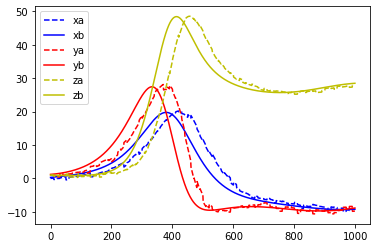

In [15]:
x0 = 0.3
y0 = 1.2
z0 = 0.95

for i in range(num_steps):
    
    xb = np.array([x0, y0, z0])
    
    Xb_evolution[0,i] = xb[0]
    
    Xb_evolution[1,i] = xb[1]
    
    Xb_evolution[2,i] = xb[2]    
           
    
    x_next, y_next, z_next = lorenz_1step(x0, y0, z0 , s=10, r=28, b=2.667, dt = 0.001)
        
    x0, y0, z0 = x_next, y_next, z_next


plt.plot(Xa_evolution[0,:],'b--',label ='xa')

plt.plot(Xb_evolution[0,:],'b',label ='xb')

plt.plot(Xa_evolution[1,:],'r--',label ='ya')

plt.plot(Xb_evolution[1,:],'r',label ='yb')

plt.plot(Xa_evolution[2,:],'y--',label ='za')

plt.plot(Xb_evolution[2,:],'y',label ='zb')

#plt.plot(row_1000,'r')

plt.legend()

plt.show()